## Step 4 - Advanced data analysis

In this step, We will perform machine learning with several types of algorithms and draw conclusions

In [1]:
!pip install xgboost

In [2]:
!pip install shap

In [140]:
import pandas as pd
import shap
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [141]:
data = pd.read_csv("IMDb_rating_data_after_scrubbing.csv",index_col = 0)
data.head()

,Name,Genre,Year,Imdb Rating,Director,Votes,Gross,malesRating,malesCount,femalesRating,femalesCount
0,The Dark Knight,Action,2008,9.0,Christopher Nolan,2573361,534.86,9.0,1480015,8.7,265210
1,The Lord of the Rings: The Return of the King,Action,2003,9.0,Peter Jackson,1786873,377.85,9.0,1030137,8.9,218645
2,Inception,Action,2010,8.8,Christopher Nolan,2283048,292.58,8.8,1263368,8.7,294017
3,The Lord of the Rings: The Two Towers,Action,2002,8.8,Peter Jackson,1613775,342.55,8.8,925097,8.7,202157
4,The Lord of the Rings: The Fellowship of the Ring,Action,2001,8.8,Peter Jackson,1807955,315.54,8.8,1025720,8.8,229858


### We will create new features that will help us analyze the data

#### Since the movie names are strings and not a numeric value, we will create a new feature

In [142]:
#TODO: try to find other interesting features from the movie name, how many words, specific words that women\men like
data['Name length'] = data.Name.str.len()

#### Because there is an unlimited number of Director, we will clear the data to a level of 15 repetitions of the same value

In [143]:
dirc = data.Director.value_counts()
print (dirc)
data.loc[dirc[dirc<15],'Director'] = 'Other'

Steven Spielberg      49
Alfred Hitchcock      45
Hayao Miyazaki        44
Clint Eastwood        35
Ron Clements          35
                      ..
Ben Lewin              1
Colm McCarthy          1
Christopher Landon     1
Sergio G. Sánchez      1
Seth MacFarlane        1
Name: Director, Length: 1208, dtype: int64


#### When we inserted the Director's feature we reached a higher accuracy

### Create new feature of Age 
##### (Some time has passed since the movie came out)

In [144]:
data['Age'] = 2022 - data["Year"]

In [145]:
data.describe()

,Year,Imdb Rating,Votes,Gross,malesRating,malesCount,femalesRating,femalesCount,Name length,Age
count,4691.000000,4691.000000,4.691000e+03,4691.000000,4691.000000,4.691000e+03,4691.000000,4691.000000,4691.000000,4691.000000
mean,1997.571946,7.553976,2.378817e+05,76.863579,7.501258,1.386465e+05,7.595118,30916.202515,15.341079,24.428054
std,21.439609,0.641831,3.075617e+05,101.605124,0.667830,1.770130e+05,0.599456,39753.877756,8.605030,21.439609
min,1920.000000,1.900000,2.503700e+04,0.000000,1.700000,2.582000e+03,2.700000,110.000000,1.000000,0.000000
25%,1989.000000,7.200000,4.925000e+04,9.545000,7.200000,2.930750e+04,7.300000,5630.500000,9.000000,9.000000
50%,2005.000000,7.600000,1.131430e+05,53.710000,7.600000,6.733400e+04,7.700000,14094.000000,13.000000,17.000000
75%,2013.000000,8.000000,2.899090e+05,76.860000,7.900000,1.730770e+05,8.000000,39731.000000,19.000000,33.000000
max,2022.000000,9.300000,2.601939e+06,936.660000,9.300000,1.480017e+06,9.400000,294019.000000,68.000000,102.000000


#### It can be seen that the 75th percentile of Year represents the year 2013
#### selecting only the features we want
#### convert categorical features to one-hot vectors

In [146]:
y = data["malesCount"]/data["femalesCount"]
cols = ['Genre',"Gross","Year","Age","Name length",'Director']
data = data[cols]
data = pd.get_dummies(data,columns=['Genre','Director']) 

#### split to train and test, also create the target variable, the ratio of how many women\men will watch

In [147]:
X_train = data[data.Year<2013]
X_test = data[data.Year>=2013] #retrospective
del X_train['Year'] #will not help us
del X_test['Year']

<AxesSubplot:>

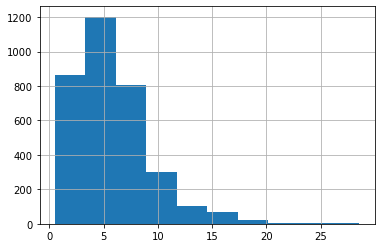

In [148]:
y_train = y[data.Year<2013]
y_test = y[data.Year>=2013]
y_train.hist()

### Here we can see that there are 1200 movies that have been seen by five men in relation to one woman 

## Algorithms tested are: Linear regression, KNN, RandomForest

In [149]:
for name,clf in [("XGBRegressor", XGBRegressor()),
                ("Linear regression",LinearRegression()),
                 ("KNN",KNeighborsRegressor()),
                 ("RF",RandomForestRegressor())]:
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    print (f"#### {name} ####")
    score = mean_absolute_error(y_test,pred)
    print ('Mean Absolute error test for is', score)
    score = mean_absolute_error(y_train,clf.predict(X_train))
    print ('Mean Absolute error train for is', score)
    print ()

#### XGBRegressor ####
Mean Absolute error test for is 2.7354702770570207
Mean Absolute error train for is 1.2580624729193948

#### Linear regression ####
Mean Absolute error test for is 2.8112864611569655
Mean Absolute error train for is 0.8907183226849898

#### KNN ####
Mean Absolute error test for is 4.021453864514384
Mean Absolute error train for is 1.5039468803517249

#### RF ####
Mean Absolute error test for is 2.791988823214564
Mean Absolute error train for is 0.5447595469432218



### We tested three types of machine learning algorithms
### We concluded that XGB Regressor  is the algorithm that gave us the best accuracy

#### Importance of properties

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


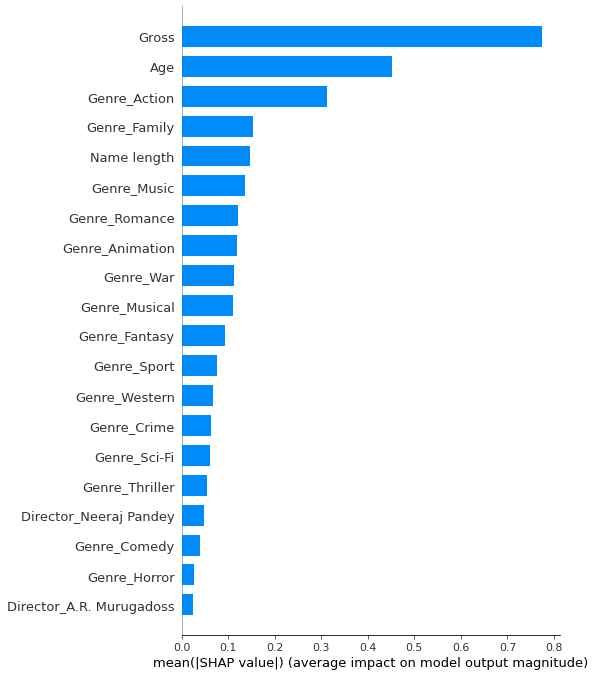

In [150]:
clf = XGBRegressor().fit(X_train,y_train)

explainer = shap.TreeExplainer(clf)
shap_values =explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [152]:
data.head()

,Gross,Year,Age,Name length,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,...,Director_Yorgos Lanthimos,Director_Yoshiaki Kawajiri,Director_Yoshifumi Kondô,Director_Yôjirô Takita,Director_Zack Snyder,Director_Zaza Urushadze,Director_Zoya Akhtar,Director_Éric Lartigau,Director_Ömer Faruk Sorak,Director_Ömer Vargi
0,534.86,2008,14,15,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,377.85,2003,19,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,292.58,2010,12,9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,342.55,2002,20,37,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,315.54,2001,21,49,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.to_csv("IMDb_rating_data_after_analysis.csv")